In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainerCallback, TrainerState, TrainerControl, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 


In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/graysonlevy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/graysonlevy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:


def load_data(directory):
    texts = []
    labels = []
    indices = [] 

    for label_type in ['pos', 'neg']:
        dir_name = os.path.join(directory, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith(".txt"):
                # Extract index from filename
                index = int(fname.split('_')[0])
                with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                indices.append(f"{label_type}_{index}")  # Track the index and folder
                # Label: positive (1) or negative (0)
                if label_type == 'pos':
                    labels.append(1)
                else:
                    labels.append(0)
    return texts, labels, indices


train_dir = 'data_/train'  
test_dir = 'data_/test'    

# Load train and test data
train_texts, train_labels, train_indices = load_data(train_dir)
test_texts, test_labels, test_indices = load_data(test_dir)

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


In [4]:
# Self verify correct input
print(f"First few train indices: {train_indices[-5:]}")
print(f"First few train labels: {train_labels[-5:]}")
train_texts[-5:]

First few train indices: ['neg_3307', 'neg_2240', 'neg_11556', 'neg_4617', 'neg_9788']
First few train labels: [0 0 0 0 0]


['My comments may be a bit of a spoiler, for what it\'s worth. Stop now if you care enough....<br /><br />Saving Grace should have been titled "A Paper-Thin Excuse for Old British Women to Get High On-Screen." This film is dumb. The incidental music is an annoyance as are the obvious, hackneyed tunes that sporadically pop up to comment on the narrative ("Spirit in the Sky," for example - Oh, I get it!) This is basically a Cheech and Chong movie made credible by its stodgy English setting and Brenda Blethyn\'s overwhelming power to inflict emotion on an audience using her voice alone. I could literally hear the folks over at High Times magazine receiving their jollies over the enormous "buds" that litter this picture. Worst scene? Easy. Brenda attempts to peddle her illicit wares on the street of London in a blaring white dress-suit. Not funny. Not original. Not interesting. Not a good movie. The 7.2 rating is the result of zealots over-voting. Don\'t waste your time...',
 'The "saucy" 

In [5]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenize the text
    words = word_tokenize(text)
    # # Remove stop words
    # words = [word for word in words if word not in stop_words]
    return ' '.join(words)


# Apply the text cleaning
train_texts = [clean_text(text) for text in train_texts]
test_texts = [clean_text(text) for text in test_texts]

In [6]:
train_texts[-5:]

['my comments may be a bit of a spoiler for what its worth stop now if you care enoughbr br saving grace should have been titled a paperthin excuse for old british women to get high onscreen this film is dumb the incidental music is an annoyance as are the obvious hackneyed tunes that sporadically pop up to comment on the narrative spirit in the sky for example oh i get it this is basically a cheech and chong movie made credible by its stodgy english setting and brenda blethyns overwhelming power to inflict emotion on an audience using her voice alone i could literally hear the folks over at high times magazine receiving their jollies over the enormous buds that litter this picture worst scene easy brenda attempts to peddle her illicit wares on the street of london in a blaring white dresssuit not funny not original not interesting not a good movie the 72 rating is the result of zealots overvoting dont waste your time',
 'the saucy misadventures of four au pairs who arrive in london on

In [7]:

# Create a dictionary with text and labels
data_dict_train = {"text": train_texts, "label": train_labels}
data_dict_test = {"text": test_texts, "label": test_labels}

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(data_dict_train)
test_dataset = Dataset.from_dict(data_dict_test)

# Split the training dataset
train_valid_split = train_dataset.train_test_split(test_size=0.2)
train_dataset = train_valid_split['train']
valid_dataset = train_valid_split['test']

In [8]:
# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Apply the tokenization function to both train and test sets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)

# Formatting to match what Hugging Face expects
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")
valid_dataset = valid_dataset.rename_column("label", "labels")

# Set format to torch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

/opt/anaconda3/envs/maui/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [38]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to("mps")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# training_args = TrainingArguments(
#     output_dir='./results',         
#     overwrite_output_dir=True,  
#     num_train_epochs=2,             
#     per_device_train_batch_size=16, 
#     per_device_eval_batch_size=16,  
#     warmup_steps=100,               
#     weight_decay=0.01,              
#     logging_dir='./logs',           
#     logging_steps=10,
#     gradient_accumulation_steps=4,
#     learning_rate=1e-4,
#     eval_strategy="epoch"      
# )

training_args = TrainingArguments(
    output_dir='./results',          
    overwrite_output_dir=True,  
    num_train_epochs=3,          
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    warmup_steps=500,               
    weight_decay=0.01,              
    logging_dir='./logs',           
    logging_steps=100,
    gradient_accumulation_steps=4,
    learning_rate=1e-4,
    eval_strategy="epoch"      
)



In [40]:
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []

    def on_log(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if "loss" in state.log_history[-1]:
            self.train_loss.append((state.global_step, state.log_history[-1]["loss"]))
        if "eval_loss" in state.log_history[-1]:
            self.eval_loss.append((state.global_step, state.log_history[-1]["eval_loss"]))

loss_logger = LossLoggerCallback()

In [41]:
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset            # evaluation dataset
)

In [42]:
trainer.add_callback(loss_logger)

trainer.train()

  0%|          | 0/1875 [00:00<?, ?it/s]

{'loss': 0.6005, 'grad_norm': 8.656708717346191, 'learning_rate': 2e-05, 'epoch': 0.16}
{'loss': 0.3135, 'grad_norm': 12.458120346069336, 'learning_rate': 4e-05, 'epoch': 0.32}
{'loss': 0.3071, 'grad_norm': 5.849188327789307, 'learning_rate': 6e-05, 'epoch': 0.48}
{'loss': 0.3257, 'grad_norm': 4.074105739593506, 'learning_rate': 8e-05, 'epoch': 0.64}
{'loss': 0.2822, 'grad_norm': 1.940343976020813, 'learning_rate': 0.0001, 'epoch': 0.8}
{'loss': 0.2835, 'grad_norm': 3.3515255451202393, 'learning_rate': 9.272727272727273e-05, 'epoch': 0.96}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.2353941947221756, 'eval_runtime': 68.9822, 'eval_samples_per_second': 72.482, 'eval_steps_per_second': 9.06, 'epoch': 1.0}
{'loss': 0.2268, 'grad_norm': 3.938886880874634, 'learning_rate': 8.545454545454545e-05, 'epoch': 1.12}
{'loss': 0.1966, 'grad_norm': 4.455935478210449, 'learning_rate': 7.818181818181818e-05, 'epoch': 1.28}
{'loss': 0.1843, 'grad_norm': 4.46476936340332, 'learning_rate': 7.090909090909092e-05, 'epoch': 1.44}
{'loss': 0.1665, 'grad_norm': 4.305513858795166, 'learning_rate': 6.363636363636364e-05, 'epoch': 1.6}
{'loss': 0.1561, 'grad_norm': 2.1696696281433105, 'learning_rate': 5.636363636363636e-05, 'epoch': 1.76}
{'loss': 0.1528, 'grad_norm': 2.5466887950897217, 'learning_rate': 4.909090909090909e-05, 'epoch': 1.92}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.21054406464099884, 'eval_runtime': 68.8988, 'eval_samples_per_second': 72.57, 'eval_steps_per_second': 9.071, 'epoch': 2.0}
{'loss': 0.1115, 'grad_norm': 0.037615805864334106, 'learning_rate': 4.181818181818182e-05, 'epoch': 2.08}
{'loss': 0.052, 'grad_norm': 0.5137200355529785, 'learning_rate': 3.454545454545455e-05, 'epoch': 2.24}
{'loss': 0.0666, 'grad_norm': 0.7368826270103455, 'learning_rate': 2.7272727272727273e-05, 'epoch': 2.4}
{'loss': 0.0513, 'grad_norm': 1.3389054536819458, 'learning_rate': 2e-05, 'epoch': 2.56}
{'loss': 0.0511, 'grad_norm': 1.7797105312347412, 'learning_rate': 1.2727272727272727e-05, 'epoch': 2.72}
{'loss': 0.0626, 'grad_norm': 0.7793963551521301, 'learning_rate': 5.4545454545454545e-06, 'epoch': 2.88}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.2755196690559387, 'eval_runtime': 69.4398, 'eval_samples_per_second': 72.005, 'eval_steps_per_second': 9.001, 'epoch': 3.0}
{'train_runtime': 44820.8754, 'train_samples_per_second': 1.339, 'train_steps_per_second': 0.042, 'train_loss': 0.19336711743672688, 'epoch': 3.0}


TrainOutput(global_step=1875, training_loss=0.19336711743672688, metrics={'train_runtime': 44820.8754, 'train_samples_per_second': 1.339, 'train_steps_per_second': 0.042, 'total_flos': 7948043919360000.0, 'train_loss': 0.19336711743672688, 'epoch': 3.0})

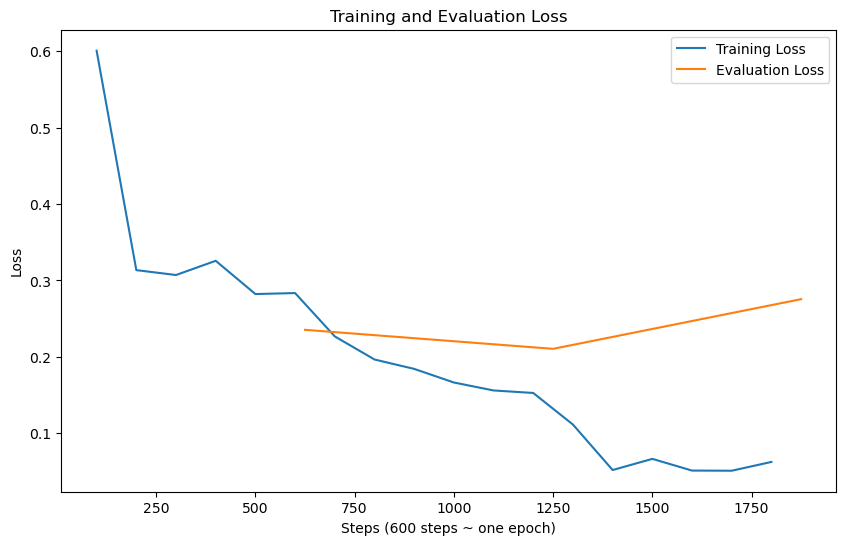

In [48]:
# Extract the logged loss values for plotting
train_steps, train_losses = zip(*loss_logger.train_loss)
eval_steps, eval_losses = zip(*loss_logger.eval_loss)

# Plotting the training and evaluation loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Evaluation Loss')
plt.xlabel('Steps (600 steps ~ one epoch)')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

In [44]:
# Predict the labels for the test set
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)


  0%|          | 0/3125 [00:00<?, ?it/s]

In [45]:
predictions_train = trainer.predict(train_dataset)
predicted_labels_train = np.argmax(predictions_train.predictions, axis=1)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [46]:
# Get true labels and predicted labels
true_labels = train_dataset["labels"]  
pred_labels = predicted_labels_train

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

print(f"Train Set")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Train Set
Accuracy: 0.9961
Precision: 0.9958756664319485
Recall: 0.9962765422159605
F1 Score: 0.9960760639903411


In [47]:

# Get true labels and predicted labels
true_labels = test_dataset["labels"]  
pred_labels = predicted_labels

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

print(f"Test Set")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Test Set
Accuracy: 0.92692
Precision: 0.9231623186107366
Recall: 0.93136
F1 Score: 0.9272430408984109
